In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
action_dict, goal_space_dict = {}, {}
action_dict["0-1"] = ["(unstack o e)", "(stack o w)", "(unstack e c)",
                        "(put-down e)", "(pick-up r)", "(stack r e)",
                        "(unstack o w)", "(stack o r)", "(pick-up c)",
                        "(stack c o)"]
goal_space_dict["0-1"] = ["power", "cower", "crow", "core", "pore"]

action_dict["0-2"] = ["(unstack p a)", "(put-down p)", "(unstack a r)",
                        "(stack a d)", "(pick-up w)",
                        "(stack w a)"]
goal_space_dict["0-2"] = ["wad", "reap", "war", "wade", "draw"]

action_dict["0-3"] = ["(unstack a w)", "(stack a p)", "(unstack r e)",
                        "(put-down r)", "(unstack a p)", "(stack a r)", "(pick-up w)",
                        "(stack w a)"]
goal_space_dict["0-3"] = ["wad", "reap", "war", "wade", "draw"]
action_dict["0-4"] = ["(unstack r o)", "(put-down r)", "(unstack c e)",
                        "(stack c p)", "(pick-up e)", "(stack e r)",
                        "(unstack o w)", "(put-down o)", "(pick-up w)",
                        "(stack w e)", "(pick-up o)", "(stack o w)",
                        "(unstack c p)", "(stack c o)"]
goal_space_dict["0-4"] = ["power", "cower", "crow", "core", "pore"]


In [5]:
font = {'size'   : 16}

matplotlib.rc('font', **font)

goal_colors = ['#0c0787', '#7e02a8',  
          '#cb4778', '#f89441', '#f0f921'] 

 # Load data and clean data

In [6]:
with open('plinf-abdee-export.json') as file:
    data = json.load(file)
results = data['results']

assignemnts_data = pd.read_csv("Batch_4270661_batch_results.csv", header=0)
assignemnts_data_2 = pd.read_csv("Batch_4270670_batch_results.csv", header=0)
id_list = np.append(assignemnts_data['Answer.experimentcode'].values, assignemnts_data_2['Answer.experimentcode'].values)
id_list = list(map(str, id_list))
workers_dict = dict.fromkeys(id_list, 0)
exp_dict = dict()


rejected =[1607115047337,
1607115070015,
1607115116358,
1607115480159,
1607115552593,
1607116558958,
1607117474340,
1607117492816,
1607125963924,
1607116912260,
1607115323722,
1607120548427,
1607126650608,
1607117907163,
1607118854103,
1607115018235,
1607117830583,
1607117440250,
1607115873532,
1607121165107,
1607117172687,
1607116510666
]

# rejected =[]


In [7]:
workers_dict = dict.fromkeys(id_list, 0)
exp_dict = dict()
for key, entry in results.items():
    key = key.split("_")
    current_id = key[0]
    if current_id not in workers_dict.keys(): 
        continue 
    if workers_dict[current_id] == 0: 
        workers_dict[current_id] = {'reward_score': 0, 'min_time': 1000000, 'default': False}
    if len(key) == 2: #the entry is tutorial
        workers_dict[current_id]['tutorial_final_prob'] = entry[-1]['true_goal_probs']  
    else: #the entry is an experiment
        exp = "_".join(key[-2:])
        if exp in exp_dict.keys(): 
            exp_dict[exp].append(current_id)
        else: 
            exp_dict[exp] = [current_id]
        workers_dict[current_id]['reward_score'] += entry[-1]['reward_score']/entry[-1]['timestep']
        time = []
        for step in entry: 
            time.append(step['time_spent'])
        if min(time) < workers_dict[current_id]['min_time'] and min(time) != 0: 
            workers_dict[current_id]['min_time'] = min(time)
        if [entry[-1]['goal_probs_0'], entry[-1]['goal_probs_1'], 
            entry[-1]['goal_probs_2'], entry[-1]['goal_probs_3'], 
            entry[-1]['goal_probs_4']] == [0.2,0.2,0.2,0.2,0.2]: 
            workers_dict[current_id]['default'] = True
            
#flaggining workers 
flagged_ids = []
for key, worker in workers_dict.items(): 
    if worker['min_time'] < 2.0 or worker['tutorial_final_prob'] < 0.7 or worker['default']: 
        worker['flag'] = True
        flagged_ids.append(key)
    else: 
        worker['flag'] = False
        
#counting experiments
exp_counter = {}
for key, exp in exp_dict.items(): 
    exp_counter[key] = {}
    exp_counter[key]['total'] = len(exp)
    intersection = list(set(exp) & set(flagged_ids)) 
    exp_counter[key]['possibly_rejected'] = len(intersection)
    
    

In [8]:
## ids_dict: primary key is user id secondary key is exeriment [tutorial, 0-1,0-2,....] 
## third level key is goal ['goal_probs_0'] and time_spent, timestep, and reward_score

ids_dict = dict.fromkeys(id_list, 0)
for key, entry in results.items():
    key = key.split("_")
    current_id = key[0]
    if current_id not in ids_dict.keys(): 
        continue
    if ids_dict[current_id] == 0: 
        ids_dict[current_id] = {}
    if len(key) == 2: #the entry is tutorial
        ids_dict[current_id]['tutorial'] = entry
    else:
        exp = "_".join(key[-2:])
        time_steps = [d['timestep'] for d in entry]
        if len(time_steps) == max(time_steps):
            ids_dict[current_id][exp] = entry
        else: 
            ids_dict[current_id][exp] = entry[7:]

In [9]:
# primary key is problem number, secondary key is timestep, values are list of dictionaries with keys column_order and additional user_id column
predictions_dict = dict()
column_order = ['goal_probs_0', 'goal_probs_1','goal_probs_2','goal_probs_3','goal_probs_4','true_goal_probs','time_spent','reward_score']

for key, entry in results.items():
    key = key.split("_")
    current_id = key[0]
    if current_id not in workers_dict.keys(): 
        continue 
    if workers_dict[current_id] == 0: 
        workers_dict[current_id] = {'reward_score': 0, 'min_time': 1000000, 'default': False}
    if len(key) == 2: #the entry is tutorial
        workers_dict[current_id]['tutorial_final_prob'] = entry[-1]['true_goal_probs']  
    else: #the entry is an experiment
        exp = "_".join(key[-2:])
        # build prediction if user not rejected

        if int(current_id) in rejected:
            print(current_id)
            continue
        predictions_dict[exp] = predictions_dict.get(exp, dict())
        for timestep in entry:
            time = timestep['timestep']
            step = {}
            # skip tutorial or bad timestep
            if timestep['time_spent'] == 0:
                continue
            for column in column_order:
                step[column] = round(timestep[column],2)
            step['user_id'] = current_id
            predictions_dict[exp][time] = predictions_dict[exp].get(time, [])
            predictions_dict[exp][time].append(step)

1607115018235
1607115018235
1607115018235
1607115047337
1607115047337
1607115047337
1607115070015
1607115070015
1607115070015
1607115116358
1607115116358
1607115116358
1607115323722
1607115323722
1607115323722
1607115480159
1607115480159
1607115480159
1607115552593
1607115552593
1607115552593
1607115873532
1607115873532
1607115873532
1607116510666
1607116510666
1607116510666
1607116558958
1607116558958
1607116558958
1607116912260
1607116912260
1607116912260
1607117172687
1607117172687
1607117172687
1607117440250
1607117440250
1607117440250
1607117474340
1607117474340
1607117474340
1607117492816
1607117492816
1607117492816
1607117830583
1607117830583
1607117830583
1607117907163
1607117907163
1607117907163
1607118854103
1607118854103
1607118854103
1607120548427
1607120548427
1607120548427
1607121165107
1607121165107
1607121165107
1607125963924
1607125963924
1607125963924
1607126650608
1607126650608
1607126650608


## Finding outliers

c:\users\joie\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
c:\users\joie\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
c:\users\joie\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences 

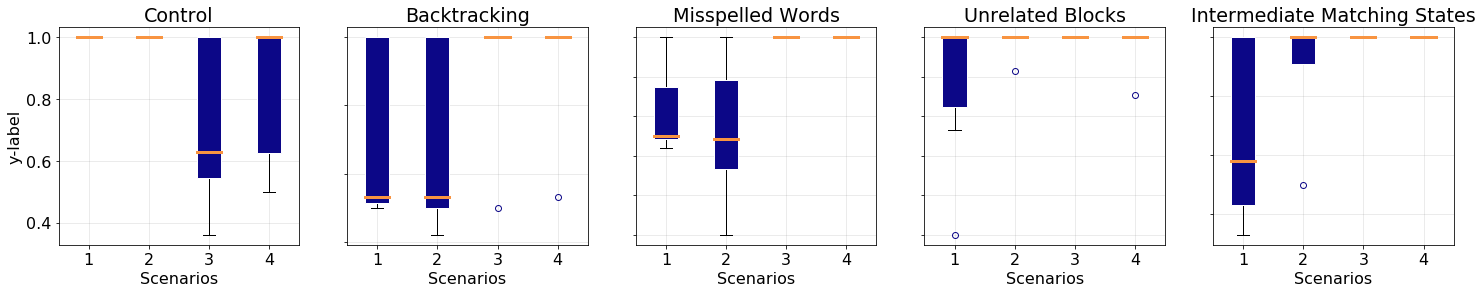

In [10]:
outliers = dict()
cutoff = 1 
i = 0
fig, axs = plt.subplots(1, 5, figsize=[25,4])
categories = ['Control', 'Backtracking', 'Misspelled Words', 'Unrelated Blocks', 'Intermediate Matching States']
for category in range(5):
    true_goals = []
    labels = []
    for scenario in range(1,5):
        exp = "{0}_{1}".format(category,scenario)
        labels.append(scenario)
        final_time = max(predictions_dict[exp].keys())
        df = pd.DataFrame.from_dict(predictions_dict[exp][final_time], orient='columns', dtype=None, columns=None)
        true_goal_probs = df['true_goal_probs'].values
        true_goals.append(true_goal_probs)
        median = np.median(true_goal_probs)
        q25, q75 = np.percentile(true_goal_probs, 25), np.percentile(true_goal_probs, 75)
        iqr = q75 - q25
        lower_limit = q25 - cutoff * iqr
        outliers_values = [x for x in true_goal_probs if x < lower_limit]
        df = df[df['true_goal_probs'] < lower_limit]
        ids_ = df['user_id'].values
#         if len(ids_): 
        outliers[exp] = ids_
    axs[category].boxplot(true_goals, widths=0.4, 
                patch_artist=True, labels = labels,
                whis = cutoff,
                boxprops=dict(facecolor=goal_colors[0], color='w'),
                medianprops = dict(linewidth=3, color=goal_colors[3]), 
                flierprops=dict(color=goal_colors[3], markeredgecolor=goal_colors[0]))
    axs[category].set_title(categories[category])
    axs[category].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
#     axs[category].setp(item, dict(facecolor=goal_colors[0], color=goal_colors[1]))

for ax in axs.flat:
    ax.set(xlabel='Scenarios', ylabel='y-label')
for ax in axs.flat:
    ax.label_outer()

fig.savefig('plots/human_data_var.png', dpi=400)

In [11]:
outliers

{'0_1': array([], dtype=object),
 '0_2': array([], dtype=object),
 '0_3': array([], dtype=object),
 '0_4': array([], dtype=object),
 '1_1': array([], dtype=object),
 '1_2': array([], dtype=object),
 '1_3': array(['1607116920161'], dtype=object),
 '1_4': array(['1607121550937'], dtype=object),
 '2_1': array([], dtype=object),
 '2_2': array([], dtype=object),
 '2_3': array([], dtype=object),
 '2_4': array([], dtype=object),
 '3_1': array(['1607115360280'], dtype=object),
 '3_2': array(['1607118182890'], dtype=object),
 '3_3': array([], dtype=object),
 '3_4': array(['1607115408614'], dtype=object),
 '4_1': array([], dtype=object),
 '4_2': array(['1607115775262'], dtype=object),
 '4_3': array([], dtype=object),
 '4_4': array([], dtype=object)}

In [12]:
# primary key is problem number, secondary key is timestep, values are list of dictionaries with keys column_order and additional user_id column
predictions_dict_cleaned = dict()
column_order = ['goal_probs_0', 'goal_probs_1','goal_probs_2','goal_probs_3','goal_probs_4','true_goal_probs','time_spent','reward_score']

for key, entry in results.items():
    key = key.split("_")
    current_id = key[0]
    if len(key) == 2: #the entry is tutorial
        continue
    else: #the entry is an experiment
        exp = "_".join(key[-2:])
        # build prediction if user not rejected
        if current_id in outliers[exp]:
            print(current_id)
            continue
        predictions_dict_cleaned[exp] = predictions_dict_cleaned.get(exp, dict())
        for timestep in entry:
            time = timestep['timestep']
            step = {}
            # skip tutorial or bad timestep
            if timestep['time_spent'] == 0:
                continue
            for column in column_order:
                step[column] = round(timestep[column],2)
            step['user_id'] = current_id
            predictions_dict_cleaned[exp][time] = predictions_dict_cleaned[exp].get(time, [])
            predictions_dict_cleaned[exp][time].append(step)
            

1607115360280
1607115408614
1607115775262
1607116920161
1607118182890
1607121550937


## Plotting probability trajectories

In [13]:
import csv

def generate_sips_mean_array(filename):
    mean_array = np.array([0,0,0,0,0])
    with open("sips_results/" + filename) as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',', quotechar='\'')
        for row in csvreader:
            if len(row) > 2:
                time = row[0]
                mean = []
                for i in range(1,6):
                    prob = row[i]
                    # parse string into float
                    prob = prob.replace("\"", "").replace("[", "").replace("]", "")
                    prob = float(prob)
                    mean.append(prob)
                mean_array = np.vstack([mean_array, np.array(mean)])
        return mean_array[1:]


In [14]:
sips_mean_array = generate_sips_mean_array('experiment-4-1.csv')
print(sips_mean_array)

[[2.00000000e-01 2.00000000e-01 2.00000000e-01 2.00000000e-01
  2.00000000e-01]
 [2.53164530e-01 2.53164530e-01 1.02243299e-07 2.40506308e-01
  2.53164530e-01]
 [1.63311930e-04 4.11660652e-01 3.64394096e-12 5.88004603e-01
  1.71432413e-04]
 [5.02728980e-06 4.02297136e-01 3.85762065e-11 5.97692809e-01
  5.02728980e-06]
 [1.78771652e-13 8.48428680e-05 3.79994270e-21 9.99915156e-01
  1.22619476e-09]
 [1.53477915e-27 2.04383551e-09 3.26230292e-35 9.99999998e-01
  1.78786821e-13]
 [8.79561320e-42 2.28649313e-18 5.32093896e-48 1.00000000e+00
  2.60660185e-17]
 [7.54007212e-56 1.96556614e-32 4.56771151e-62 1.00000000e+00
  5.54055275e-25]
 [6.47270481e-69 3.84513699e-44 2.68948953e-72 1.00000000e+00
  4.25146580e-30]]


In [15]:
plot_exp = ['1_1','1_2', '1_3', '1_4']
# plot_exp = predictions_dict_cleaned.keys()

def plot_probs(exp):
    c,p = exp.split("_")
    filename = "experiment-" + str(c) + "-" + str(p) + ".csv"
    sips_mean_array= generate_sips_mean_array(filename)

    fig, axs = plt.subplots(2, 1, figsize=[25,8])
    huma_data = predictions_dict_cleaned[exp]
    mean_array = np.array([0,0,0,0,0])
    std_array = np.array([0,0,0,0,0])
    for step, data in huma_data.items(): 
        goals_probs = pd.DataFrame.from_dict(data, orient='columns', dtype=None, columns=None)
        goals_probs = goals_probs[['goal_probs_0', 'goal_probs_1', 'goal_probs_2', 'goal_probs_3', 'goal_probs_4']].values
        mean = np.mean(goals_probs, axis=0)
        std = np.std(goals_probs, axis=0)
        mean_array = np.vstack([mean_array, mean])
        std_array = np.vstack([std_array, std])
    mean_array = mean_array[1:]
    std_array = std_array[1:]
    for i in range(mean_array.shape[1]): 
        axs[0].plot(range(1, mean_array.shape[0]*2+1,2), mean_array[:,i], color=goal_colors[i], linewidth=4)
        axs[0].scatter(range(1, mean_array.shape[0]*2+1,2), mean_array[:,i], color=goal_colors[i])
        axs[0].fill_between(range(1, mean_array.shape[0]*2+1,2), mean_array[:,i] - std_array[:,i], mean_array[:,i] + std_array[:,i], color=goal_colors[i], alpha=0.2)
    title = exp.split("_")
    axs[0].set_title("{0} Scenario {1}".format(categories[int(title[0])], title[1]))
    axs[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.2)
    axs[0].set_ylim([-0.01,1.01])
    axs[0].set_xlim([1,sips_mean_array.shape[0]])
    for i in range(sips_mean_array.shape[1]): 
        axs[1].plot(range(1, sips_mean_array.shape[0]+1), sips_mean_array[:,i], color=goal_colors[i], linewidth=4)
        axs[1].scatter(range(1, sips_mean_array.shape[0]+1), sips_mean_array[:,i], color=goal_colors[i])
    title = exp.split("_")
    axs[1].set_title("SIPS {0} Scenario {1}".format(categories[int(title[0])], title[1]))
    axs[1].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.2)
    axs[1].set_ylim([-0.01,1.01])
    axs[1].set_xlim([1,sips_mean_array.shape[0]])
    fig.savefig('plots/sips/prob_traj_{}.png'.format(exp), dpi=400)
    print(sips_mean_array.shape)
    print(mean_array)    

(13, 5)
[[0.23       0.18454545 0.20727273 0.18818182 0.18909091]
 [0.22       0.17454545 0.24       0.18454545 0.18272727]
 [0.27       0.23909091 0.17181818 0.16818182 0.15181818]
 [0.25363636 0.28181818 0.14727273 0.18545455 0.13090909]
 [0.36363636 0.35545455 0.10272727 0.08818182 0.08909091]
 [0.32545455 0.52181818 0.05363636 0.05363636 0.04727273]
 [0.64363636 0.20090909 0.05363636 0.05363636 0.04727273]]
(13, 5)
[[0.23333333 0.24       0.18444444 0.17888889 0.16333333]
 [0.46666667 0.32666667 0.04444444 0.08555556 0.07555556]
 [0.56111111 0.28888889 0.04444444 0.05555556 0.04888889]
 [0.55555556 0.30666667 0.04111111 0.05       0.04444444]
 [0.50888889 0.36111111 0.04444444 0.03555556 0.04888889]
 [0.43444444 0.43555556 0.04444444 0.03555556 0.04888889]
 [0.27666667 0.60111111 0.04222222 0.03333333 0.04555556]]
(13, 5)
[[0.19375 0.19875 0.19875 0.20375 0.20375]
 [0.0675  0.0675  0.08875 0.45    0.325  ]
 [0.0975  0.085   0.18625 0.33875 0.29125]
 [0.0675  0.055   0.26    0.33125

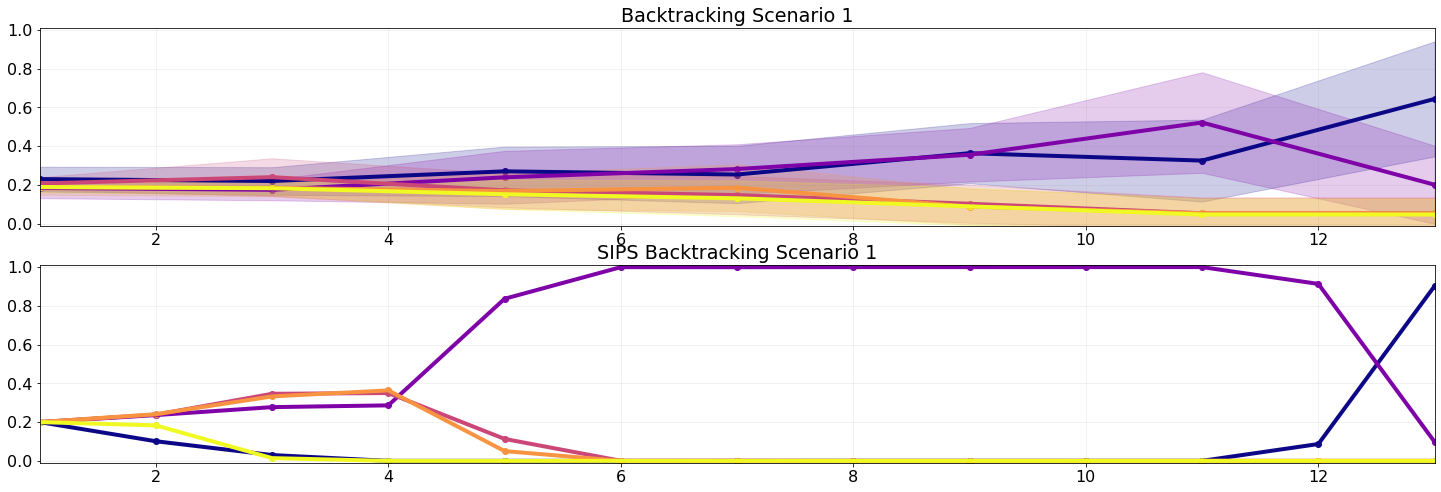

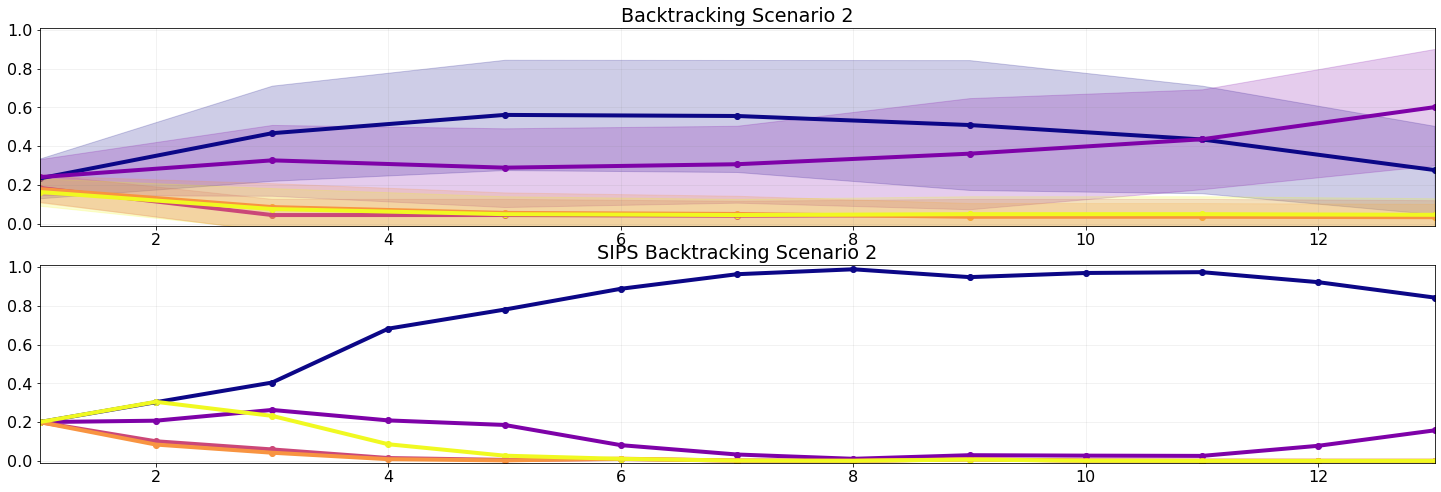

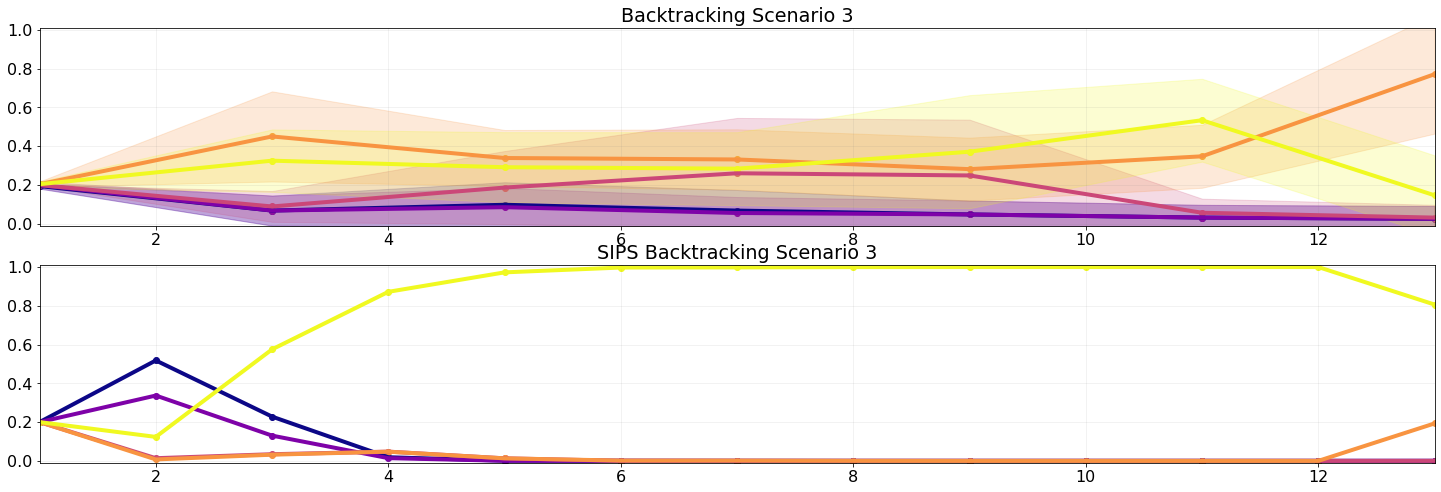

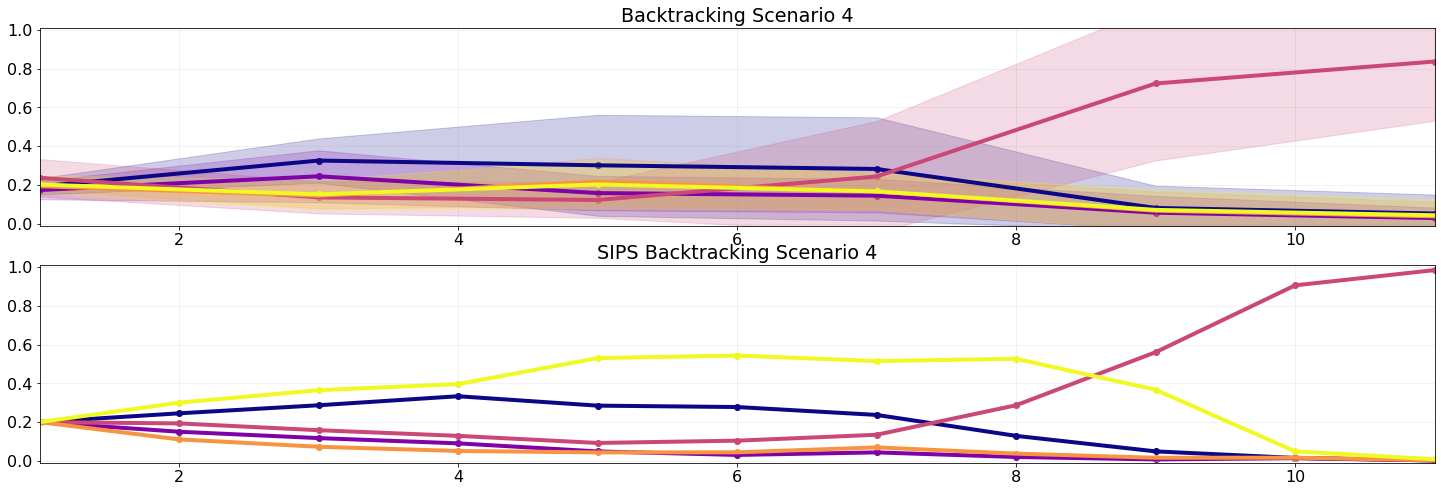

In [16]:
for exp in plot_exp:
    plot_probs(exp)

In [13]:
plot_exp = ['2_1','2_2', '2_3', '2_4']
# plot_exp = predictions_dict_cleaned.keys()

def plot_probs(exp):
    c,p = exp.split("_")
    filename = "experiment-" + str(c) + "-" + str(p) + ".csv"
    sips_mean_array= generate_sips_mean_array(filename)

    fig, axs = plt.subplots(2, 1, figsize=[25,8])
    huma_data = predictions_dict_cleaned[exp]
    mean_array = np.array([0,0,0,0,0])
    std_array = np.array([0,0,0,0,0])
    for step, data in huma_data.items(): 
        goals_probs = pd.DataFrame.from_dict(data, orient='columns', dtype=None, columns=None)
        goals_probs = goals_probs[['goal_probs_0', 'goal_probs_1', 'goal_probs_2', 'goal_probs_3', 'goal_probs_4']].values
        mean = np.mean(goals_probs, axis=0)
        std = np.std(goals_probs, axis=0)
        mean_array = np.vstack([mean_array, mean])
        std_array = np.vstack([std_array, std])
    mean_array = mean_array[1:]
    std_array = std_array[1:]
    for i in range(mean_array.shape[1]): 
        axs[0].plot(range(1, mean_array.shape[0]*2+1,2), mean_array[:,i], color=goal_colors[i], linewidth=4)
        axs[0].scatter(range(1, mean_array.shape[0]*2+1,2), mean_array[:,i], color=goal_colors[i])
        axs[0].fill_between(range(1, mean_array.shape[0]*2+1,2), mean_array[:,i] - std_array[:,i], mean_array[:,i] + std_array[:,i], color=goal_colors[i], alpha=0.2)
    title = exp.split("_")
    axs[0].set_title("{0} Scenario {1}".format(categories[int(title[0])], title[1]))
    axs[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.2)
    axs[0].set_ylim([-0.01,1.01])
    axs[0].set_xlim([1,sips_mean_array.shape[0]])
    for i in range(sips_mean_array.shape[1]): 
        axs[1].plot(range(1, sips_mean_array.shape[0]+1), sips_mean_array[:,i], color=goal_colors[i], linewidth=4)
        axs[1].scatter(range(1, sips_mean_array.shape[0]+1), sips_mean_array[:,i], color=goal_colors[i])
    title = exp.split("_")
    axs[1].set_title("SIPS {0} Scenario {1}".format(categories[int(title[0])], title[1]))
    axs[1].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.2)
    axs[1].set_ylim([-0.01,1.01])
    axs[1].set_xlim([1,sips_mean_array.shape[0]])
    fig.savefig('plots/sips/prob_traj_{}.png'.format(exp), dpi=400)
    print(sips_mean_array.shape)
    print(mean_array)

    ## Include SIPS inference in axis 2
    
    

(25, 5)
[[0.2   0.194 0.214 0.197 0.194]
 [0.197 0.191 0.209 0.206 0.198]
 [0.18  0.192 0.198 0.221 0.21 ]
 [0.274 0.3   0.135 0.144 0.148]
 [0.192 0.256 0.172 0.197 0.185]
 [0.238 0.295 0.156 0.153 0.157]
 [0.207 0.356 0.11  0.14  0.187]
 [0.228 0.385 0.112 0.142 0.132]
 [0.228 0.385 0.112 0.142 0.132]
 [0.228 0.385 0.112 0.142 0.132]
 [0.28  0.459 0.069 0.099 0.092]
 [0.349 0.449 0.067 0.07  0.064]
 [0.301 0.526 0.052 0.061 0.06 ]]
(19, 5)
[[0.1675     0.1575     0.1725     0.21333333 0.28666667]
 [0.16583333 0.14583333 0.255      0.2075     0.22666667]
 [0.18       0.18       0.26416667 0.18833333 0.1875    ]
 [0.24333333 0.1325     0.17083333 0.26666667 0.1875    ]
 [0.245      0.14833333 0.24833333 0.1725     0.18583333]
 [0.23083333 0.12083333 0.295      0.175      0.17833333]
 [0.14916667 0.12333333 0.42416667 0.1475     0.15333333]
 [0.09833333 0.11583333 0.21833333 0.3525     0.21333333]
 [0.08583333 0.09333333 0.0925     0.405      0.32083333]
 [0.09916667 0.07583333 0.091666

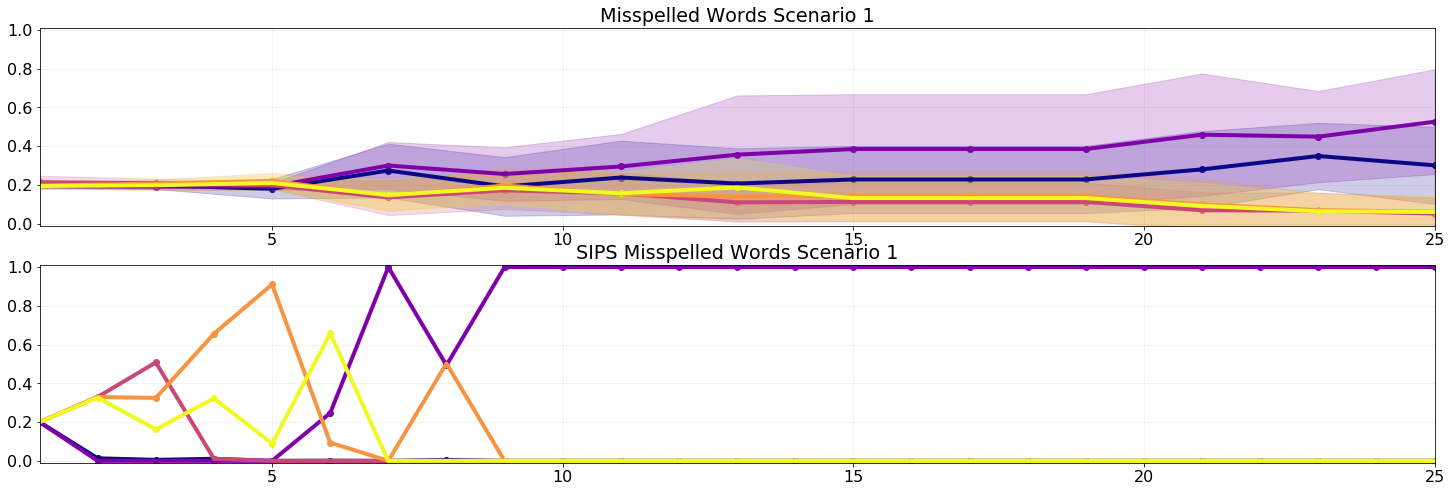

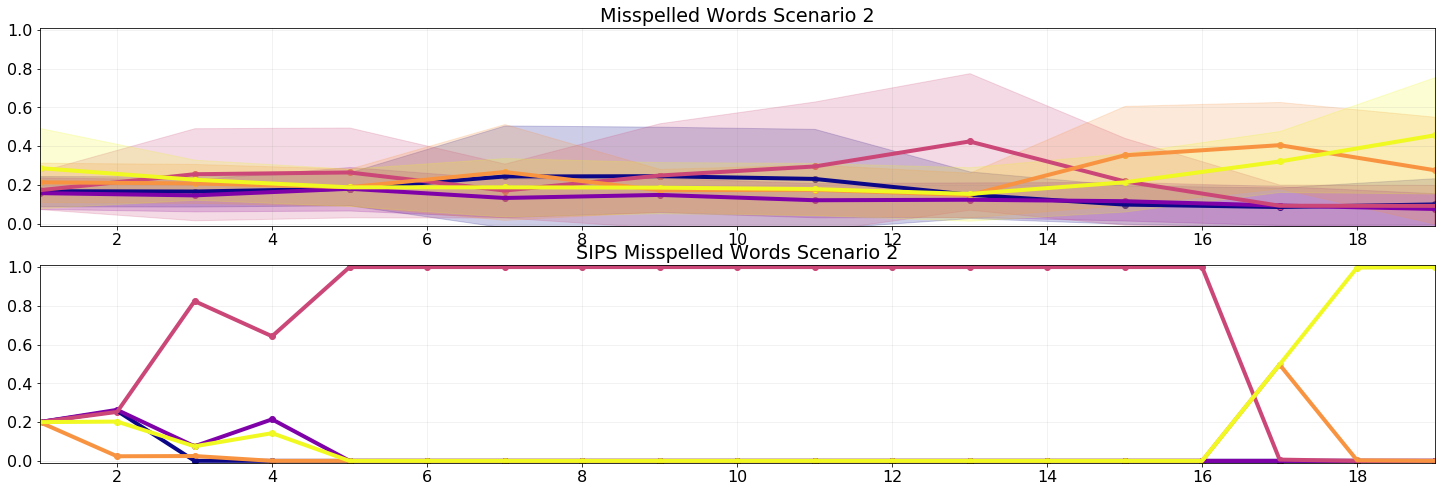

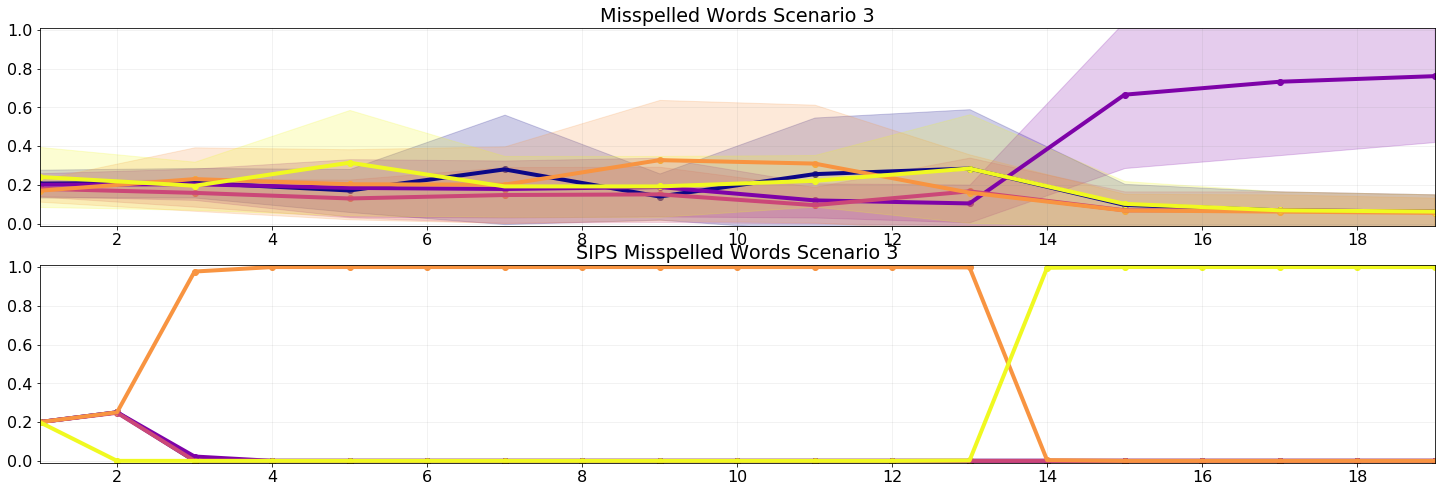

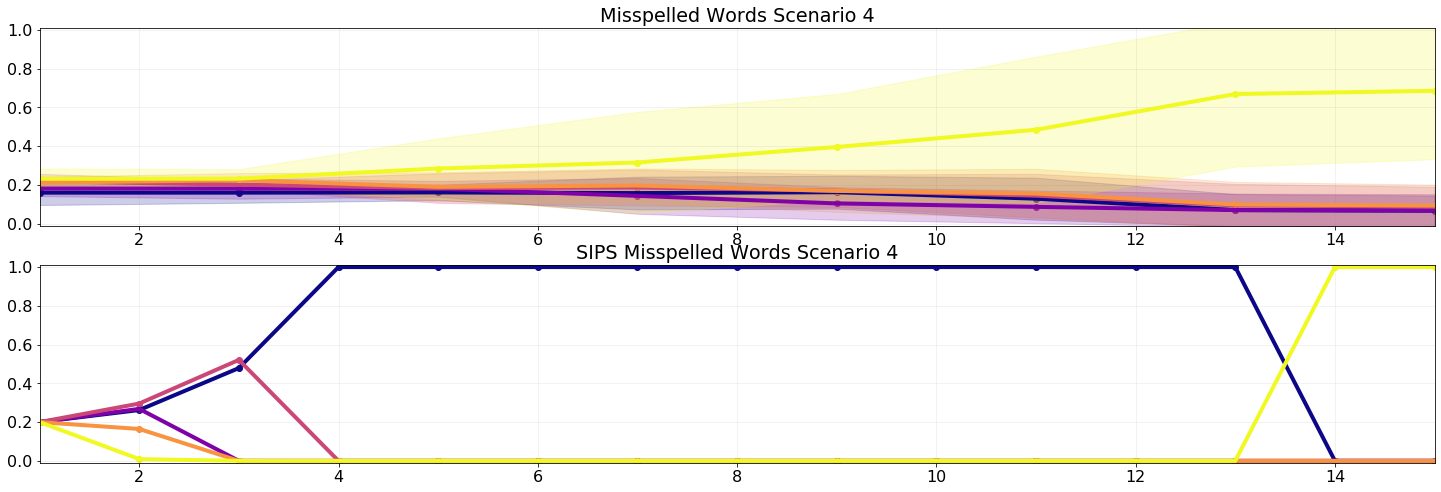

In [14]:
for exp in plot_exp:
    plot_probs(exp)

In [15]:
# build averaged dictionary
avg_dict = dict()
averaged_columns = ['goal_probs_0', 'goal_probs_1','goal_probs_2','goal_probs_3','goal_probs_4','true_goal_probs','time_spent']

for exp in predictions_dict_cleaned:
    avg_dict[exp] = []
    for time in predictions_dict_cleaned[exp]:
        timestep_average = dict()
        for result in predictions_dict[exp][time]:
            for column in averaged_columns:
                timestep_average[column] = timestep_average.get(column, 0)
                timestep_average[column] += result[column]
            timestep_average["timestep"] = time
        for column in averaged_columns:
            timestep_average[column] =  round(timestep_average[column]/len(predictions_dict_cleaned[exp][time]), 4)
        avg_dict[exp].append(timestep_average)

[[0.2   0.194 0.214 0.197 0.194]
 [0.197 0.191 0.209 0.206 0.198]
 [0.18  0.192 0.198 0.221 0.21 ]
 [0.274 0.3   0.135 0.144 0.148]
 [0.192 0.256 0.172 0.197 0.185]
 [0.238 0.295 0.156 0.153 0.157]
 [0.207 0.356 0.11  0.14  0.187]
 [0.228 0.385 0.112 0.142 0.132]
 [0.228 0.385 0.112 0.142 0.132]
 [0.228 0.385 0.112 0.142 0.132]
 [0.28  0.459 0.069 0.099 0.092]
 [0.349 0.449 0.067 0.07  0.064]
 [0.301 0.526 0.052 0.061 0.06 ]]


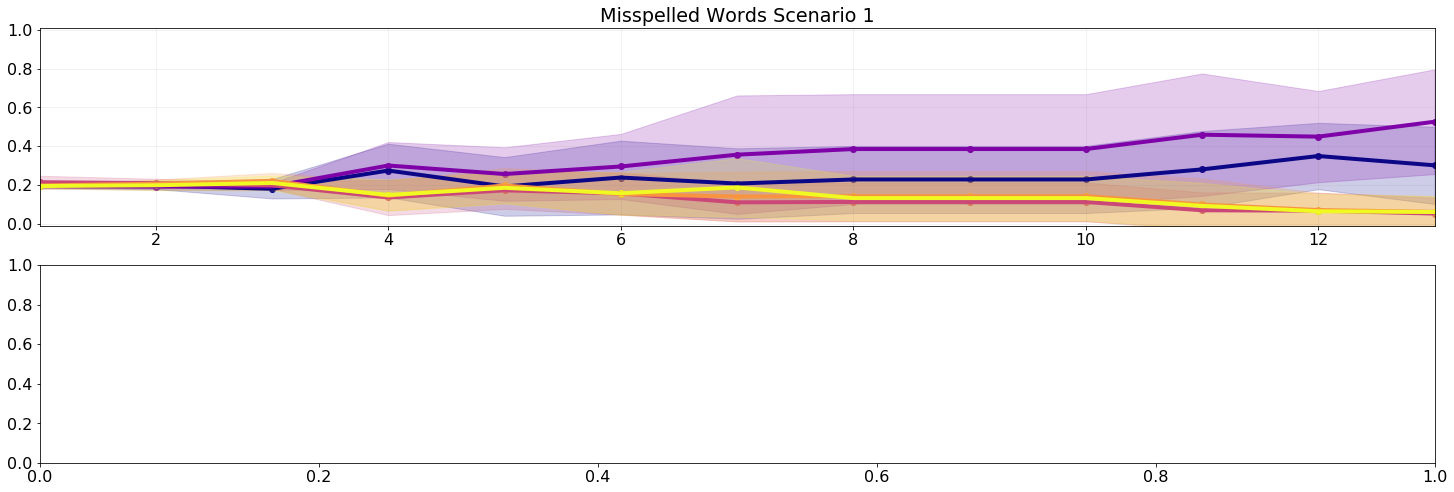

In [16]:
plot_exp = ['2_1']
# plot_exp = predictions_dict_cleaned.keys()

for exp in plot_exp: 
    fig, axs = plt.subplots(2, 1, figsize=[25,8])
    huma_data = predictions_dict_cleaned[exp]
    mean_array = np.array([0,0,0,0,0])
    std_array = np.array([0,0,0,0,0])
    for step, data in huma_data.items(): 
        goals_probs = pd.DataFrame.from_dict(data, orient='columns', dtype=None, columns=None)
        goals_probs = goals_probs[['goal_probs_0', 'goal_probs_1', 'goal_probs_2', 'goal_probs_3', 'goal_probs_4']].values
        mean = np.mean(goals_probs, axis=0)
        std = np.std(goals_probs, axis=0)
        mean_array = np.vstack([mean_array, mean])
        std_array = np.vstack([std_array, std])
    mean_array = mean_array[1:]
    std_array = std_array[1:]
    print(mean_array)
    for i in range(mean_array.shape[1]): 
        axs[0].plot(range(1, mean_array.shape[0]+1), mean_array[:,i], color=goal_colors[i], linewidth=4)
        axs[0].scatter(range(1, mean_array.shape[0]+1), mean_array[:,i], color=goal_colors[i])
        axs[0].fill_between(range(1, mean_array.shape[0]+1), mean_array[:,i] - std_array[:,i], mean_array[:,i] + std_array[:,i], color=goal_colors[i], alpha=0.2)
    title = exp.split("_")
    axs[0].set_title("{0} Scenario {1}".format(categories[int(title[0])], title[1]))
    axs[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.2)
    axs[0].set_ylim([-0.01,1.01])
    axs[0].set_xlim([1,mean_array.shape[0]])
    fig.savefig('plots/prob_traj_{}.png'.format(exp), dpi=400)
    ## Include SIPS inference in axis 2
    